In [418]:
%load_ext autoreload
%autoreload 2
from naml.modules import torch, nn, optim, tqdm
from naml.util import run_epochs
from naml import plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [419]:
def f(x : torch.Tensor):
    return torch.sin(x) + x**0.8 

noise = 0.5
n_train = 50

x_train, indices = torch.sort(torch.rand(n_train) * 5)
y_train = f(x_train) + torch.normal(0, 0.5, x_train.shape) * noise

x_test = torch.linspace(0, 5, n_train)
y_true = f(x_test)

x_train, y_train

(tensor([0.0873, 0.2460, 0.2836, 0.3100, 0.3493, 0.7007, 0.7701, 0.7863, 1.1014,
         1.2363, 1.2465, 1.2565, 1.8487, 2.0551, 2.1951, 2.4838, 2.5204, 2.6263,
         2.7087, 2.7820, 2.8403, 2.8844, 2.8884, 2.9610, 2.9867, 3.1295, 3.1950,
         3.2096, 3.3845, 3.5955, 3.6360, 3.7041, 3.7365, 3.8162, 4.0873, 4.2021,
         4.2419, 4.3716, 4.4091, 4.5630, 4.6451, 4.6648, 4.6792, 4.7406, 4.7673,
         4.7989, 4.7992, 4.8941, 4.9808, 4.9832]),
 tensor([0.1019, 0.6239, 0.5660, 0.8352, 0.2331, 1.2529, 1.2359, 1.5820, 2.0763,
         1.7688, 2.0442, 2.1028, 3.0300, 2.4086, 2.5430, 2.2406, 2.8791, 2.4630,
         2.6214, 2.8577, 2.6694, 2.8325, 3.0559, 2.9117, 2.7965, 2.5588, 2.5258,
         2.3505, 2.4890, 2.7971, 2.3817, 2.3491, 2.1565, 2.1186, 1.7490, 2.3302,
         2.5710, 1.8918, 2.8086, 2.4842, 2.7977, 2.3585, 2.1443, 2.4383, 2.6435,
         2.5007, 2.5503, 2.9498, 2.8562, 2.9526]))

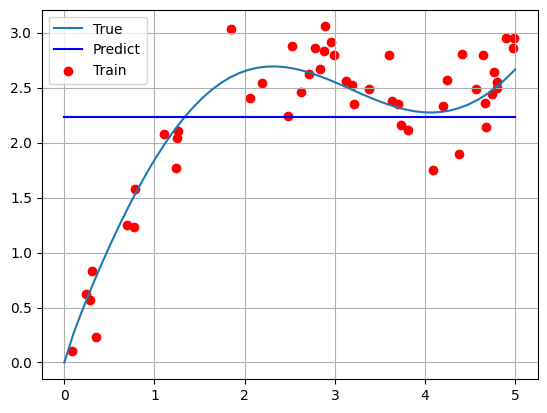

In [420]:
# Average pooling
y_hat = torch.repeat_interleave(y_train.mean(), n_train)
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

In [421]:
# Weighted with Gaussian kernel
x_repeat = x_test.repeat_interleave(n_train).reshape(-1, n_train)
x_repeat, x_train

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1020, 0.1020, 0.1020,  ..., 0.1020, 0.1020, 0.1020],
         [0.2041, 0.2041, 0.2041,  ..., 0.2041, 0.2041, 0.2041],
         ...,
         [4.7959, 4.7959, 4.7959,  ..., 4.7959, 4.7959, 4.7959],
         [4.8980, 4.8980, 4.8980,  ..., 4.8980, 4.8980, 4.8980],
         [5.0000, 5.0000, 5.0000,  ..., 5.0000, 5.0000, 5.0000]]),
 tensor([0.0873, 0.2460, 0.2836, 0.3100, 0.3493, 0.7007, 0.7701, 0.7863, 1.1014,
         1.2363, 1.2465, 1.2565, 1.8487, 2.0551, 2.1951, 2.4838, 2.5204, 2.6263,
         2.7087, 2.7820, 2.8403, 2.8844, 2.8884, 2.9610, 2.9867, 3.1295, 3.1950,
         3.2096, 3.3845, 3.5955, 3.6360, 3.7041, 3.7365, 3.8162, 4.0873, 4.2021,
         4.2419, 4.3716, 4.4091, 4.5630, 4.6451, 4.6648, 4.6792, 4.7406, 4.7673,
         4.7989, 4.7992, 4.8941, 4.9808, 4.9832]))

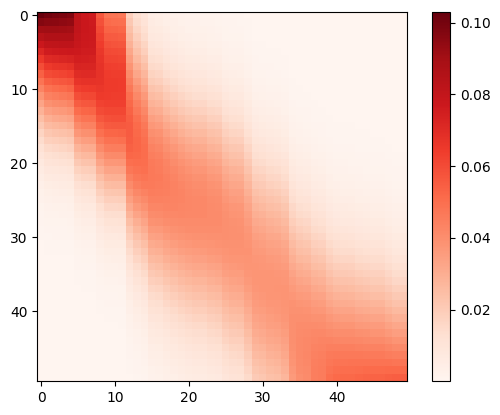

In [422]:
# Closer points have higher weights
w = nn.functional.softmax(-((x_repeat - x_train)**2) / 2, dim=1)
plot.heatmap(w)

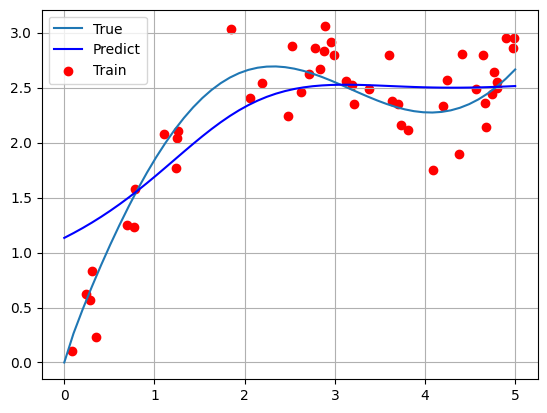

In [423]:
# Nadaraya-Watson kernel regression
y_hat = w @ y_train
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

In [424]:
class Net(nn.Module):
    M_w : torch.Tensor
    w : nn.Parameter

    def __init__(self):
        super().__init__()
        # Hyperparameter tuning
        # We're only learning the w parameter
        self.w = nn.Parameter(torch.randn(1), requires_grad=True)
        
    def forward(self, q : torch.Tensor, k : torch.Tensor, v : torch.Tensor):
        M_q = q.repeat_interleave(k.shape[-1]).reshape(-1, k.shape[1])
        self.M_w = M_w = nn.functional.softmax(-(((M_q - k) * self.w) **2) / 2, dim=1)
        return (M_w.unsqueeze(1) @ v.unsqueeze(-1)).reshape(-1) # Flatten
    
x_tiled = x_train.repeat((n_train,1))
y_tiled = y_train.repeat((n_train,1))

print((1-torch.eye(n_train)).bool())
k, v = x_tiled, y_tiled
print(k.shape, v.shape)
# Samples are not allowed to attend to themselves
# XXX: What if we allow this?
k, v = x_tiled[(1-torch.eye(n_train)).bool()], y_tiled[(1-torch.eye(n_train)).bool()]
k, v = k.reshape(-1, n_train-1), v.reshape(-1, n_train-1)
print(k.shape, v.shape)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])
torch.Size([50, 50]) torch.Size([50, 50])
torch.Size([50, 49]) torch.Size([50, 49])


In [425]:
# Train
net = Net()
loss = nn.MSELoss(reduction='none')
list(net.parameters())

[Parameter containing:
 tensor([-0.7903], requires_grad=True)]

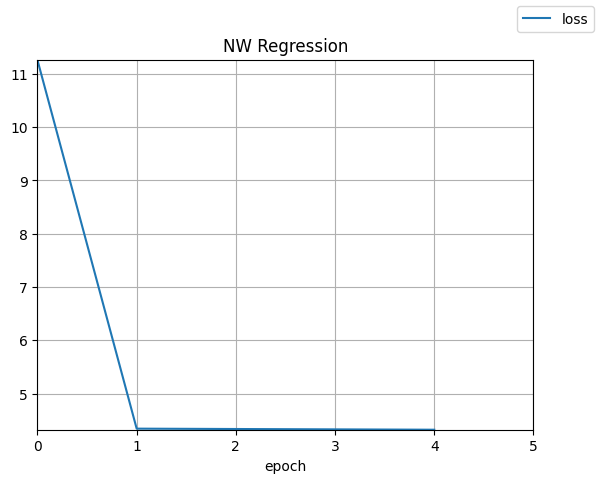

  0%|          | 0/5 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

In [426]:
opt = optim.SGD(net.parameters(), lr=0.5)
@run_epochs("NW Regression")
def train():
    opt.zero_grad()
    l : torch.Tensor = loss(net(x_train, k, v), y_train)
    l.sum().backward()
    opt.step()        
    return l.sum().detach()
train(5)

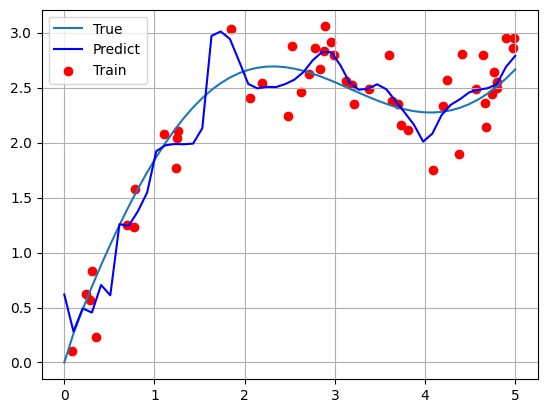

In [427]:
y_hat = net(x_test, k, v).unsqueeze(1).detach()
plot.kernel_regression(y_hat, y_true, x_test, y_train, x_train)

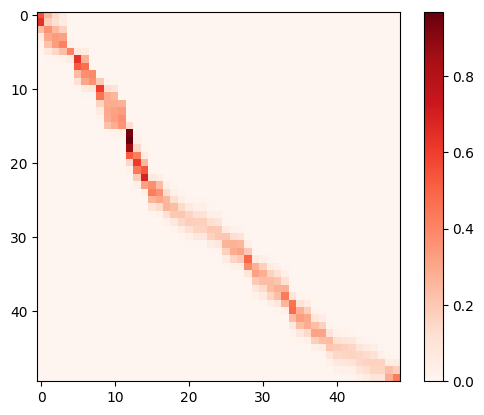

In [428]:
plot.heatmap(net.M_w)